# MR-Longitudinal Radiomics
### Radiomics pipeline created for longitudinal images collected at subsequent fractions of treatment.
##### Full model: Feature Extraction, Feature Reduction via volume correlation & test-retest stability, Feature Selection via Euclidean distance between feature pair trajectories and hierachical clustering.
##### Compares the results of the longitudinal model with a standard delta-radiomics approach to illustrate the importance of accounting for the full feature trajectory over treatment.

###
#### Below specify certain variables and options for customising the notebook

In [1]:
import os
import pandas as pd
from tqdm import tqdm

# Specify the output path
# specify the tag to use - could be anything, helps to identify the output if running multiple models
# default is "Test"
tag = "HM-FS-FinalRS-Delta"
# output_path = "C:/Users/b01297ar/Documents/ProstateMRL-local/ProstateMRL-Radiomics/ReleaseCode/Output/" + tag + "/"
cwd = os.getcwd()
output_path = cwd + "/Output/" 
if os.path.exists(output_path) == False:
        os.mkdir(output_path)
if os.path.exists(output_path + tag) == False:
    os.mkdir(output_path + tag)
    os.mkdir(output_path + tag + "/Features/")
    os.mkdir(output_path + tag + "/Extraction/")
    os.mkdir(output_path + tag + "/Plots/")
output_path = cwd + "/Output/" + tag + "/"

# specify if you want to compare to a delta model
# default is False
Delta_Model = False

# Specify if you want to visualise the results in plots
# default is False, can specify at given stages below if you want to visualise
plot = False

# Specify if you want to extract Features
# default is False, option to do so is below
# If features are already extracted, set to false and provide the path to the extracted features below
extract = True


## Feature Extraction
#### If you want to extract features, provide a csv containing the following:
####               | PatID | Fraction | Image file | Mask Name | Mask file | 
#### Specify the root of the csv in the Input dir.
#### Calculates features based on the parameter file specified. Default setting is currently set at PyRadiomics base extraction parameters - Fixed bin size (FBS) of 25, no resampling, no normalisation, 107 features (IBSI compliant) and no wavelet/laplacian filters applied. 
#### Features are then calculated and then saved in a new folder in the Output dir - with files in parquet format. Columns will be:
#### PatID | Fraction | Mask | Feature | Feature Value |

#### Once all features have been extracted, combine in to one dataframe
#### Or
#### Specify the path of the feature values. 
##### Default is to read in a parquet file (smaller file sizes - so quicker), make sure to change to pd.read_csv if reading in csv and change path.

In [2]:

if os.path.exists(output_path + "/Features/Features_All.csv") == False:
    df_all = pd.read_csv('Input/Default/Features_HM-FS.csv')
    df_all.to_csv(output_path + "/Features/Features_All.csv")
else:
    df_all = pd.read_csv(output_path + "/Features/Features_All.csv")

In [3]:
df_all = pd.read_csv('Input/Default/Features_All.csv')
df_all

,PatID,Fraction,Contour,ContourType,Feature,FeatureValue
0,1601,1,RP,Manual,shape_Elongation,0.847156
1,1601,1,RP,Manual,shape_Flatness,0.687529
2,1601,1,RP,Manual,shape_LeastAxisLength,20.722302
3,1601,1,RP,Manual,shape_MajorAxisLength,30.140250
4,1601,1,RP,Manual,shape_Maximum2DDiameterColumn,31.321124
...,...,...,...,...,...,...
21395,1553,5,Limbus,Auto,ngtdm_Busyness,30.261441
21396,1553,5,Limbus,Auto,ngtdm_Coarseness,0.000638
21397,1553,5,Limbus,Auto,ngtdm_Complexity,48.214040
21398,1553,5,Limbus,Auto,ngtdm_Contrast,0.003416


In [4]:
df_all = df_all[~df_all["Feature"].isin(["firstorder_Minimum", "firstorder_Maximum"])]

df_all = df_all[df_all["Fraction"].isin([1, 5])]

patIDs = df_all["PatID"].unique()
fts = df_all["Feature"].unique()
Contours = df_all["ContourType"].unique()

df_all["Delta"] = 0

for pat in patIDs:
    for ft in fts:
        for ct in Contours:
            df_all.loc[(df_all["PatID"] == pat) & (df_all["Feature"] == ft) & (df_all["ContourType"] == ct), "Delta"] = df_all.loc[(df_all["PatID"] == pat) & (df_all["Feature"] == ft) & (df_all["ContourType"] == ct), "FeatureValue"].diff()
        
df_all.drop(columns=["FeatureValue"], inplace=True)
df_all.rename(columns={"Delta": "FeatureValue"}, inplace=True)

df_all = df_all[df_all["Fraction"] == 5]

df_all.head()

,PatID,Fraction,Contour,ContourType,Feature,FeatureValue
428,1601,5,RP,Manual,shape_Elongation,0.026751
429,1601,5,RP,Manual,shape_Flatness,-0.023634
430,1601,5,RP,Manual,shape_LeastAxisLength,-1.104368
431,1601,5,RP,Manual,shape_MajorAxisLength,-0.590490
432,1601,5,RP,Manual,shape_Maximum2DDiameterColumn,-0.907090


In [5]:
df_man = df_all.loc[df_all["ContourType"] == "Manual"]
df_limbus = df_all.loc[df_all["ContourType"] == "Auto"]

In [6]:
def RescaleFts(df):
    '''
    Rescale features to be between -1 and 1 across all patients
    '''
    from sklearn.preprocessing import MinMaxScaler
    
    df = df.copy()

    # Get the features
    fts = df["Feature"].unique()
    for ft in fts:
        # Get the feature
        df_ft = df.loc[df["Feature"] == ft]
        # Get the values
        vals = df_ft["FeatureValue"].values
        vals = MinMaxScaler(feature_range=(0,1)).fit_transform(vals.reshape(-1,1))
        # Replace
        df.loc[df["Feature"] == ft, "FeatureValue"] = vals

    return df

df_man = RescaleFts(df_man)
df_limbus = RescaleFts(df_limbus)

# Feature Reduction
#### Due to the high dimensionnality of radiomics values, it is vital that some of the features are removed if they offer no unique information. 
#### Since features are calculated by applying different formulas to images, many of these formulas are similar and so some features can be quite similar. We aim to remove all redundant features - redundant features in this model are those that are strongly correlated to volume, Spearman Rank coefficient rho > 0.6 and unstable due to contour differences, as measured by an ICC value < 0.5.

In [7]:
from Functions import Reduction as FR

## Volume Correlation
#### Previous studies have shown that radiomic feature values have a strong correlation with the volume of the mask



In [8]:
df_man.head()

c:\Users\b01297ar\Documents\ProstateMRL-local\ProstateMRL-Radiomics\envPR\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,PatID,Fraction,Contour,ContourType,Feature,FeatureValue
428,1601,5,RP,Manual,shape_Elongation,0.596710
429,1601,5,RP,Manual,shape_Flatness,0.072907
430,1601,5,RP,Manual,shape_LeastAxisLength,0.093920
431,1601,5,RP,Manual,shape_MajorAxisLength,0.346160
432,1601,5,RP,Manual,shape_Maximum2DDiameterColumn,0.415250


In [9]:
df_limbus.head()

,PatID,Fraction,Contour,ContourType,Feature,FeatureValue
963,1601,5,Limbus,Auto,shape_Elongation,0.100935
964,1601,5,Limbus,Auto,shape_Flatness,0.182238
965,1601,5,Limbus,Auto,shape_LeastAxisLength,0.411421
966,1601,5,Limbus,Auto,shape_MajorAxisLength,0.760187
967,1601,5,Limbus,Auto,shape_Maximum2DDiameterColumn,0.342571


In [10]:
print("Manual")
FR.Volume(df_man, output_path, plot=False)
print("Limbus")
FR.Volume(df_limbus, output_path, plot=False)

Manual
------------------------------
Volume Correlation
Correlating features to volume...


100%|██████████| 105/105 [00:00<00:00, 492.82it/s]


Volume redundant features: 11/105
------------------------------
Limbus
------------------------------
Volume Correlation
Correlating features to volume...


100%|██████████| 105/105 [00:00<00:00, 401.73it/s]

Volume redundant features: 8/105
------------------------------


## ICC Stability
#### Intra-class correlation coefficient is used as a statistical measure of how much two observed quantities within a group tend to agree with each other. 
#### Been used widely within radiomics studies as a test-retest stability measure between two delineations.



In [11]:
FR.ICC(df_all, output_path, plot=False)

------------------------------
Stability Test
Calculating ICC...


100%|██████████| 105/105 [00:04<00:00, 21.75it/s]

ICC redudant features: 37/105
------------------------------


#### Remove redundant features

#### Still need to do further feature reduction

In [12]:
df_red = FR.RemoveFts(df_man, output_path)

df_red

------------------------------
Removing redundant features...
Number of features removed: 37
Number of features remaining: 68
------------------------------


,PatID,Fraction,Contour,ContourType,Feature,FeatureValue
442,1601,5,RP,Manual,firstorder_10Percentile,0.162162
443,1601,5,RP,Manual,firstorder_90Percentile,0.092308
445,1601,5,RP,Manual,firstorder_Entropy,0.000000
446,1601,5,RP,Manual,firstorder_InterquartileRange,0.488372
449,1601,5,RP,Manual,firstorder_MeanAbsoluteDeviation,0.408456
...,...,...,...,...,...,...
20857,1553,5,RP,Manual,gldm_SmallDependenceEmphasis,0.736778
20858,1553,5,RP,Manual,gldm_SmallDependenceHighGrayLevelEmphasis,0.709114
20859,1553,5,RP,Manual,gldm_SmallDependenceLowGrayLevelEmphasis,0.476433
20860,1553,5,RP,Manual,ngtdm_Busyness,0.133299


## Clustering I - Distance between Feature Trajectories
#### Calculate the Euclidean distance between feature pairs.
#### Distance values can then be used to visualise the relationship between features.
#### Can also be used to group features together.

In [13]:
from Functions import Delta as Dl

Dl.CorrMatrix(df_red, True, output_path, plot=False)

Calculating Delta Correlation pairs...
Rescaling Features...


68it [00:01, 38.43it/s]


## Clustering II - Grouping Features
#### Hierarchical clustering using SciPy
####   - Weighted linkage (Refers to the algorithm by which clusters are formed)
####   - Starting T-val = 2 (Refers to the threshold value for which to go to a different cluster, i.e. how far away a value is to a cluster before a new cluster is created/put in another cluster.)
##### Clusters with < 3 features discarded as deemed too unstable.
##### Clusters with > 10 features re-clustered to subclusters. 


## Clustering III - Feature Selection
#### Cross-correlation value between feature trajectories within each cluster performed to determine most “representative” feature
####    - Highest mean cross-correlation passed through.
####    - Top 20% of features.
#### Each patient passes through a set of features.
#### Features then tallied up and the top 10 ranked features are selected.


array_corr.shape:  (68, 68)
results.shape:  (68, 68)


100%|██████████| 68/68 [00:00<00:00, 18868.26it/s]

Selected Features: (11)
firstorder_MeanAbsoluteDeviation
firstorder_Variance
glcm_ClusterTendency
glcm_Contrast
glcm_DifferenceAverage
glcm_DifferenceEntropy
glcm_SumSquares
glrlm_GrayLevelVariance
gldm_GrayLevelVariance
gldm_SmallDependenceEmphasis
gldm_SmallDependenceHighGrayLevelEmphasis


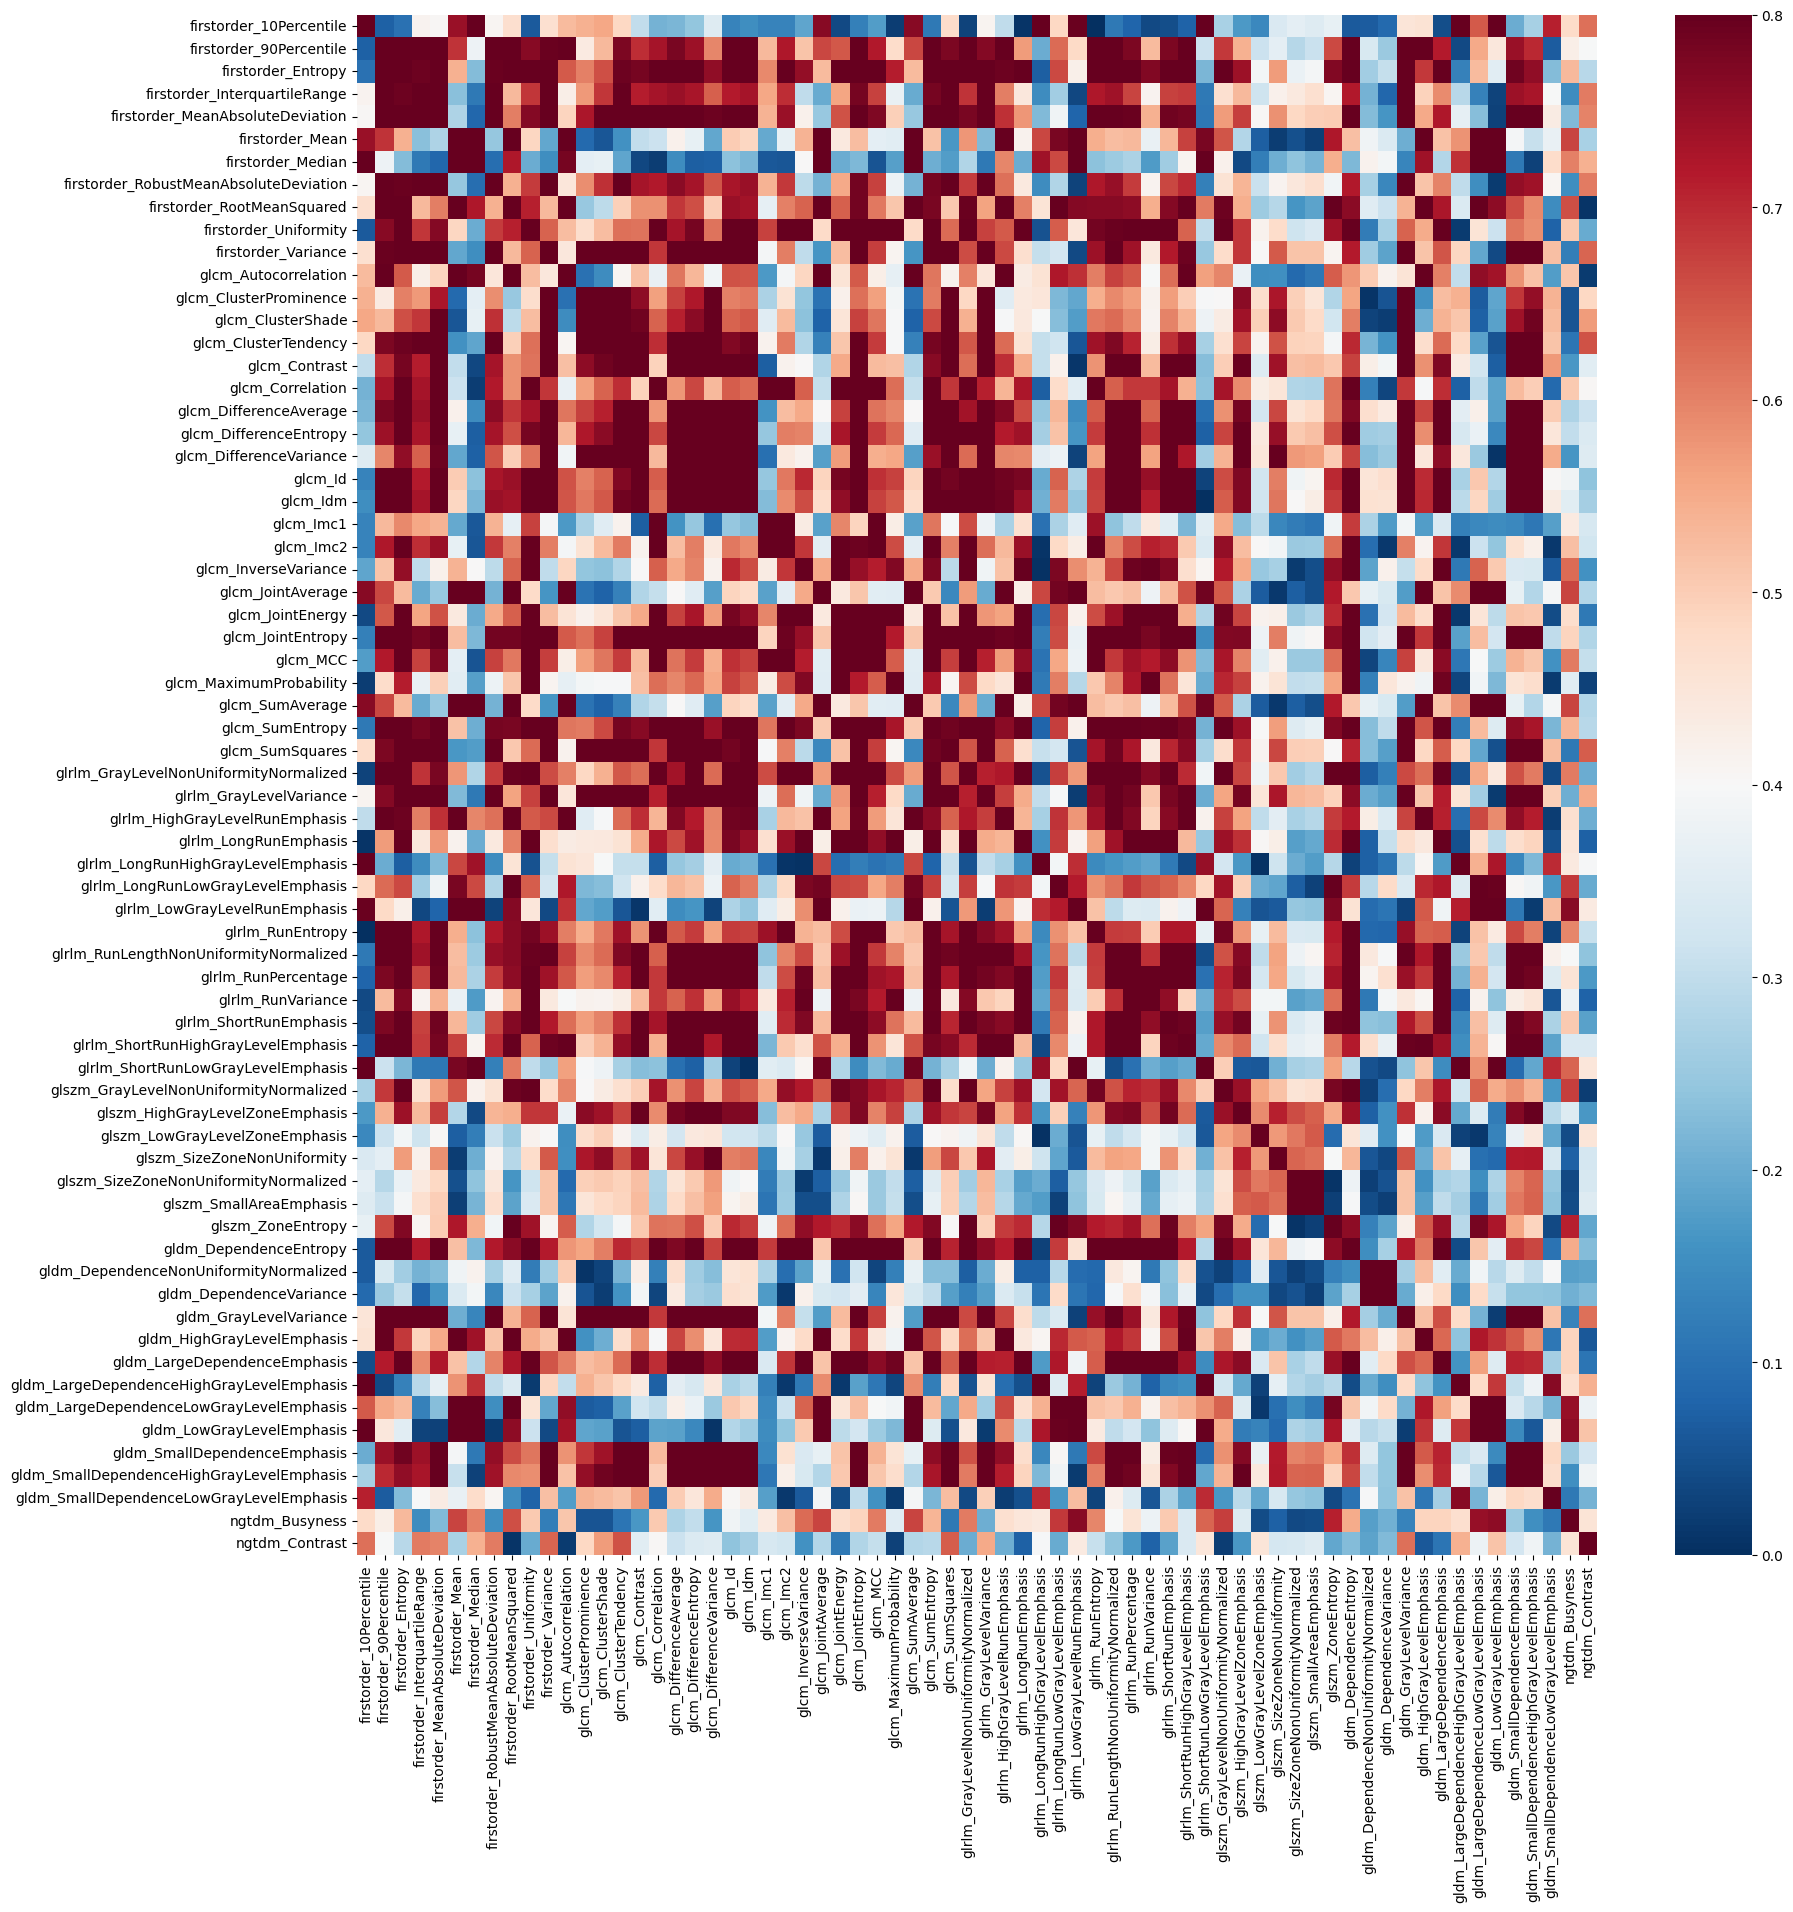

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import pingouin as pg
from scipy import stats
import sys
from Functions import UsefulFunctions as UF
from sklearn.preprocessing import MinMaxScaler 

def FeatureSelection(df, outdir):
    # read in fts from csv

    df_corr = pd.read_csv(outdir + "CM\\CorrMatrix.csv")
    fts = df['Feature'].unique()
    array_corr = df_corr.values[:,1:]
    array_corr = abs(array_corr)

    results = np.zeros((len(fts), len(fts)))
    selected_fts = []

    print('array_corr.shape: ', array_corr.shape)
    print('results.shape: ', results.shape)


    for i in tqdm(range(len(fts))):
        for j in range(len(fts)):
            
            if array_corr[i,j] <= 0.8:
                results[i,j] = array_corr[i,j]
                selected_fts.append([fts[i], fts[j]])
            else:
                results[i,j] = 1

    df_res = pd.DataFrame(results, columns=fts, index=fts)
    # plt.figure(figsize=(20,20))
    # sns.heatmap(df_res, cmap="RdBu_r", vmin=0, vmax=0.5, square=False)
    # plt.show()

    # loop through results with ft pairs and select ft with lowest mean value
    # create an empty array to store the results

    # heatmap of results
    plt.figure(figsize=(20,20))
    sns.heatmap(df_res, cmap="RdBu_r", vmin=0, vmax=0.8, square=False)
   # plt.show()

    fts_keep = []
    fts_remove = []
     
    for i in range(len(selected_fts)):
        # select ft pair
        df_ft1 = df_corr[df_corr["Unnamed: 0"] == selected_fts[i][0]]
        df_ft2 = df_corr[df_corr["Unnamed: 0"] == selected_fts[i][1]]
        # get mean values across row
        mean_ft1 = float(df_ft1.mean(axis=1))
        mean_ft2 = float(df_ft2.mean(axis=1))

        # compare mean values
        if mean_ft1 > mean_ft2:
            fts_keep.append(selected_fts[i][0])
            fts_remove.append(selected_fts[i][1])
        else:
            fts_keep.append(selected_fts[i][1])
            fts_remove.append(selected_fts[i][0])
        
    # remove duplicates
    fts_keep = list(dict.fromkeys(fts_keep))
    fts_remove = list(dict.fromkeys(fts_remove))

    # compare lists
    fts_keep2 = [x for x in fts_keep if x not in fts_remove]

    # save results
    df_fts = pd.DataFrame(fts_keep2, columns=["Feature"])
    print("Selected Features: ({})".format(str(len(fts_keep2))))
    fts = df_fts["Feature"].values
    for ft in fts:
        print(ft)
    df_fts.to_csv(outdir + "Features\\Delta_SelectedFeatures.csv", index=False)

FeatureSelection(df_red, output_path)

In [15]:
long = pd.read_csv(output_path.replace("-Delta", "") + "Features/Features_Selected.csv")
delta = pd.read_csv(output_path + "Features/Features_Selected.csv")

long_fts = long["Feature"].unique()
delta_fts = delta["Feature"].unique()

sim_fts = [x for x in long_fts if x not in delta_fts]
print(sim_fts)
print(len(sim_fts))

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\Paper1-Release/Output/HM-FS-FinalRS/Features/Features_Selected.csv'